In [2]:
# Carga de paquetes necesarios para graficar
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Para leer archivos
import geopandas as gpd # Para hacer cosas geogr√°ficas
import seaborn as sns # Para hacer plots lindos
import networkx as nx # Construcci√≥n de la red en NetworkX
import scipy

# Preambulo

En esta secci√≥n cargamos los datos y los visualizamos. Tambi√©n construimos la matriz de adyacencia de la red de museos.

## Carga de datos de los museos

El listado de los museos, con el que se construye el [mapa](https://mapas.museosabiertos.org/museos/caba/), lo podemos encontrar [ac√°](https://github.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/blob/principal/data/export.geojson?short_path=bc357f3). Tambi√©n descargamos los barrios de CABA como complemento para los gr√°ficos.

In [3]:
# Leemos el archivo, retenemos aquellos museos que est√°n en CABA, y descartamos aquellos que no tienen latitud y longitud
museos = gpd.read_file('https://raw.githubusercontent.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/refs/heads/principal/data/export.geojson')
barrios = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson')

## Visualizaci√≥n

<Axes: >

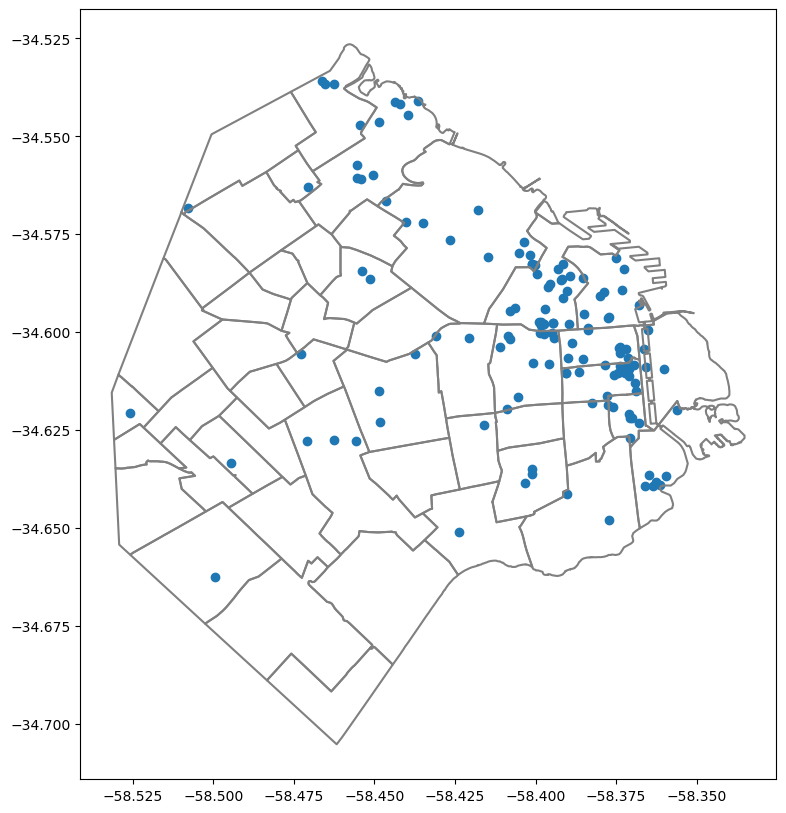

In [4]:
# Armamos el gr√°fico para visualizar los museos
fig, ax = plt.subplots(figsize=(10, 10))
barrios.boundary.plot(color='gray',ax=ax)
museos.plot(ax=ax)

## C√°lculo de la matriz de distancias

Ahora construimos la matriz de distancias entre todos los museos. Como la tierra es un [geoide](https://es.wikipedia.org/wiki/Geoide) (es decir que no es [plana](https://es.wikipedia.org/wiki/Terraplanismo)), el c√°lculo de distancias no es una operaci√≥n obvia. Una opci√≥n es proyectar a un [sistema de coordenadas local](https://geopandas.org/en/stable/docs/user_guide/projections.html), de forma tal que las distancias euclideas se correspondan con las distancias en metros. En este notebook usamos [EPSG](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset) 22184. 

In [5]:
# En esta l√≠nea:
# Tomamos museos, lo convertimos al sistema de coordenadas de inter√©s, extraemos su geometr√≠a (los puntos del mapa), 
# calculamos sus distancias a los otros puntos de df, redondeamos (obteniendo distancia en metros), y lo convertimos a un array 2D de numpy
D = museos.to_crs("EPSG:22184").geometry.apply(lambda g: museos.to_crs("EPSG:22184").distance(g)).round().to_numpy()

### Matriz de adyacencia: construimos una matriz conectando a cada museo con los $m$ m√°s cercanos

In [6]:
def construye_adyacencia(D,m): 
    # Funci√≥n que construye la matriz de adyacencia del grafo de museos
    # D matriz de distancias, m cantidad de links por nodo
    # Retorna la matriz de adyacencia como un numpy.
    D = D.copy()
    l = [] # Lista para guardar las filas
    for fila in D: # recorriendo las filas, anexamos vectores l√≥gicos
        l.append(fila<=fila[np.argsort(fila)[m]] ) # En realidad, elegimos todos los nodos que est√©n a una distancia menor o igual a la del m-esimo m√°s cercano
    A = np.asarray(l).astype(int) # Convertimos a entero
    np.fill_diagonal(A,0) # Borramos diagonal para eliminar autolinks
    return(A)

m = 3 # Cantidad de links por nodo
A = construye_adyacencia(D,m)

## Construcci√≥n de la red en NetworkX (s√≥lo para las visualizaciones)

In [7]:
G = nx.from_numpy_array(A) # Construimos la red a partir de la matriz de adyacencia
# Construimos un layout a partir de las coordenadas geogr√°ficas
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

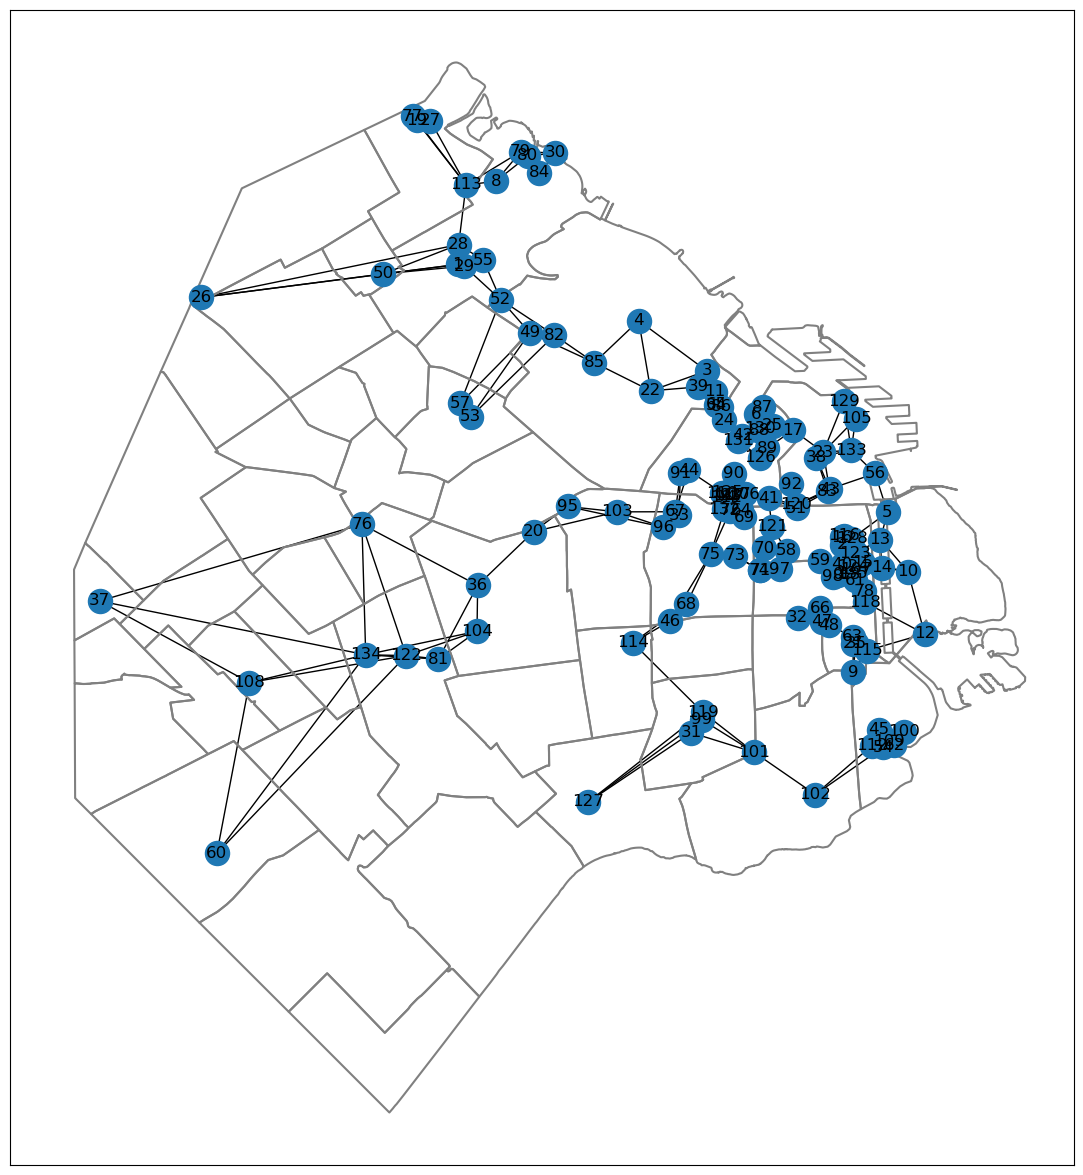

In [8]:
fig, ax = plt.subplots(figsize=(15, 15)) # Visualizaci√≥n de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
nx.draw_networkx(G,G_layout,ax=ax) # Graficamos los museos

# Resoluci√≥n del TP

## Punto 1: 
----
Partiendo de la ecuaci√≥n

$$
\mathbf{p} = (1-\alpha) C \mathbf{p} + \frac{\alpha}{N} \mathbf{1}
$$

muestre que el vector de rankings **p** es soluci√≥n de la ecuaci√≥n     $M\mathbf{p} = \mathbf{b}$  , con    $M = \frac{N}{\alpha}(I - (1-\alpha)C)$    y    $\mathbf{b} = \mathbf{1}$  .


### Resoluci√≥n

La ecuaci√≥n es:

$$
\mathbf{p} = (1-\alpha)C\mathbf{p} + \frac{\alpha}{N}\mathbf{1},
$$

luego:

$$\mathbf{p} - (1-\alpha)C\mathbf{p} = \frac{\alpha}{N}\mathbf{1}$$

equivale a

$$\mathbf{p}I - (1-\alpha)C\mathbf{p} = \frac{\alpha}{N}\mathbf{1}$$

equivale a

$$(I - (1-\alpha)C)\mathbf{p} = \frac{\alpha}{N}\mathbf{1}$$

equivale a

$$\frac{N}{\alpha}(I - (1-\alpha)C)\mathbf{p} = \mathbf{1}$$

y con $M = \frac{N}{\alpha}(I - (1-\alpha)C)$ resulta lo pedido: $M\mathbf{p} = \mathbf{b} = \mathbf{1}$.


## Punto 2:
----
¬øQu√© condiciones se deben cumplir para que exista una √∫nica soluci√≥n a la ecuaci√≥n del
punto anterior? ¬øSe cumplen estas condiciones para la matriz $M$ tal como fue construida
para los museos, cuando $0 < \alpha < 1$? Demuestre que se cumplen o d√© un contraejemplo.


Dado el √≠tem anterior, la ecuaci√≥n $Mp = 1$ tendr√° soluci√≥n √∫nica cuando $M$ sea inversible. Una condici√≥n necesaria y suficiente para esto es que el n√∫cleo de $M$ sea $\{0\}$.

Primero, usando el tip dado en clase, pruebo:

$$
\text{Si} \quad B \in \mathbb{R}^{n \times n} \quad \text{y} \quad \|B\|_1 < 1 \quad \text{entonces} \quad (I-B) \quad \text{es inversible}.
$$

Supongamos que existe $(I-B)^{-1}$. Entonces, si existiera $x \neq 0$ en $\mathbb{R}^{n}$ tal que $(I-B)x = 0$, tendr√≠amos:

$$
x - Bx = 0
$$

lo que equivale a

$$
x = Bx.
$$

Uso la norma-1 (que preserva la igualdad) y puedo suponer que $\|x\|_1 = 1$. Entonces:

$$
\|x\|_1 = \|Bx\|_1 \quad \Rightarrow \quad 1 = \|Bx\|_1.
$$

Adem√°s, se cumple que $\|Bx\|_1 \leq \|B\|_1 \|x\|_1$ y, usando la hip√≥tesis $\|B\|_1 < 1$, resulta:

$$
\|Bx\|_1 \leq \|B\|_1 \|x\|_1 = \|B\|_1 < 1.
$$

Por lo tanto, tenemos que:

$$
\|Bx\|_1 = 1 \quad \text{y} \quad \|Bx\|_1 < 1,
$$

lo cual es imposible. Como lo √∫nico que supusimos fue que $x \neq 0$, debe ser entonces que solamente se cumple $(I-B)x = 0$ si $x = 0$. Por lo tanto, $(I-B)$ es inversible.

---

Volviendo al problema original: $Mp = 1$ tendr√° soluci√≥n √∫nica si la matriz $M$ resulta inversible, es decir, si $(I - (1-\alpha)C)$ es inversible.

Por un lado, observamos que $\|C\|_1 = 1$ dado que, por definici√≥n, sus columnas suman 1. Por otro lado, como $0 < \alpha < 1$, se cumple que $1-\alpha < 1$.

Es decir:

$$
\|(1-\alpha)C\|_1 = (1-\alpha)\|C\|_1 < 1.
$$

Esto es an√°logo al problema anterior sobre la existencia de $(I-B)^{-1}$, por lo tanto $(I - (1-\alpha)C)^{-1}$ existe, y la soluci√≥n $p$ es √∫nica con la matriz $M$ y $\alpha$ as√≠ definidos.


## Punto 3:
----
Usando la factorizaci√≥n $LU$ implementada, encuentre el vector $\mathbf{p} = M^{-1} \mathbf{b}$ en los siguientes casos:

**a.** Construyendo la red conectando a cada museo con sus $m = 3$ vecinos m√°s cercanos, calculen el Page Rank usando $\alpha = 1/5$. Visualicen la red asignando un tama√±o a cada nodo proporcional al Page Rank que le toca.

**b.** Construyendo la red conectando a cada museo con sus $m$ vecinos m√°s cercanos, para $m = 1, 3, 5, 10$ y usando $\alpha = 1/

**c.** Para $m = 5$, considerando los valores de $\alpha = 6/7, 4/5, 2/3, 1/2, 1/3, 1/5, 1/7$

-----

Usando los valores de $\mathbf{p}$ obtenidos para cada caso,

**a.** Identifiquen los 3 museos m√°s centrales (para cada $m$ y cada $\alpha$) y grafiquen sus puntajes (valores de Page Rank) en funci√≥n del par√°metro a variar (es decir, en funci√≥n de $m$ o de $\alpha$). ¬øSon estables las posiciones en el ranking? Describa los distintos patrones que observa, identificando qu√© ubicaciones son relevantes en cada caso. ¬øHay museos que s√≥lo son relevantes en redes con pocas conexiones? ¬øO museos que se vuelven m√°s relevantes mientras m√°s conexiones aparecen?

**b.** Construyan visualizaciones del mapa, usando el Page Rank para representar el tama√±o de cada museo. ¬øQu√© regiones se vuelven m√°s predominantes al aumentar $\alpha$? ¬øY al aumentar $m$?


In [9]:
import importlib
import numpy as np
import matplotlib.pyplot as plt
import template_funciones as tf
from IPython.display import display
importlib.reload(tf)

<module 'template_funciones' from 'C:\\Users\\Draken\\Dropbox\\UBA\\ALC\\TP1\\template_funciones.py'>

In [11]:
# Definimos los valores de m a analizar
valores_m = [1, 3, 5, 10]
alfa_fijo = round(1/5, 5)

# Diccionarios para guardar matrices de adyacencia, grafos y pageranks
adyacencias_m = {}
grafos_m = {}
pageranks_m = {}

for m in valores_m:
    A = tf.construye_adyacencia(D, m)
    adyacencias_m[m] = A
    grafos_m[m] = nx.from_numpy_array(A)
    pageranks_m[m] = tf.calcula_pagerank(A, alfa_fijo)

# PageRank para distintos valores de Œ± con m=5 fijo
valores_alfa = [round(6/7, 5), round(4/5, 5), round(2/3, 5), round(1/2, 5), round(1/3, 5), round(1/5, 5), round(1/7, 5)]
m_fijo = 5
A_fijo = adyacencias_m[m_fijo]  # Ya lo calculamos arriba

pageranks_alfa = {}

for alfa in valores_alfa:
    alfa_key = round(alfa, 5)  # Redondeamos para evitar errores al usar un float como key
    p = tf.calcula_pagerank(A_fijo, alfa)
    pageranks_alfa[alfa_key] = p
    
# Layouts
coords = museos.to_crs("EPSG:22184").get_coordinates()
G_layout = {i: (x, y) for i, (x, y) in enumerate(zip(coords['x'], coords['y']))}

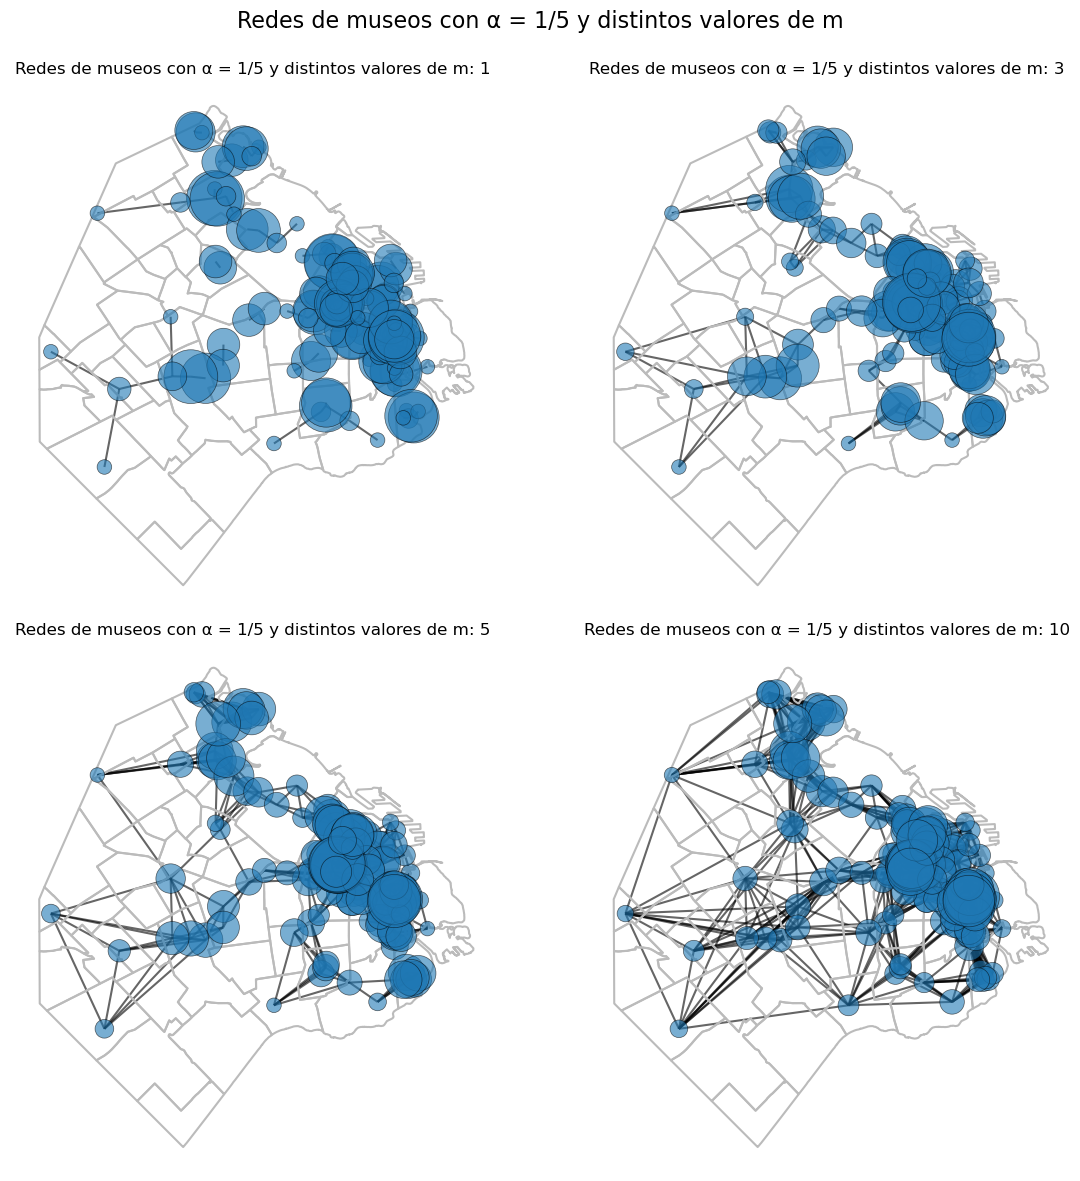

In [12]:
# Mostrar redes para distintos m (con Œ± = 1/5 fijo)
tf.graficar_redes_museos_set(
    grafos=grafos_m,
    pageranks=pageranks_m,
    G_layout=G_layout,
    barrios=barrios,
    titulo_general="Redes de museos con Œ± = 1/5 y distintos valores de m"
)

En estos gr√°ficos se observa c√≥mo var√≠a la red de museos al modificar el par√°metro $m$, que indica con cu√°ntos vecinos se conecta cada museo (sus $m$ m√°s cercanos). A medida que $m$ aumenta, la red se vuelve progresivamente m√°s densa, y eso tiene consecuencias sobre la distribuci√≥n del PageRank.

Con valores bajos de $m$ (por ejemplo, $m = 1$ o $m = 3$), la red presenta una estructura m√°s fragmentada: aparecen peque√±as zonas relativamente aut√≥nomas, en las que ciertos museos son centrales dentro de su subregi√≥n (por ejemplo, museos ubicados en Caballito y Flores, la zona norte de CABA y Microcentro). Esto se refleja en el PageRank, donde varios nodos perif√©ricos en el grafo completo tienen una alta centralidad dentro de su grupo local.

Sin embargo, a medida que $m$ aumenta (por ejemplo, en $m = 10$), estas subregiones comienzan a conectarse entre s√≠ y se forma una estructura m√°s integrada. En este contexto, los nodos centrales del Microcentro y los de la zona norte empiezan a dominar el ranking, desplazando a aquellos que antes eran importantes solo dentro de su vecindario. Es decir, pasamos de una red con m√∫ltiples polos locales de centralidad a una red con una o dos zonas centrales m√°s clara y dominante.

Este comportamiento muestra c√≥mo el valor de $m$ influye en el grado de descentralizaci√≥n de la red: con $m$ bajos emergen estructuras locales, mientras que con $m$ altos la red converge hacia un patr√≥n de conectividad m√°s global, en el que solo unos pocos nodos concentran la mayor parte del PageRank.


---

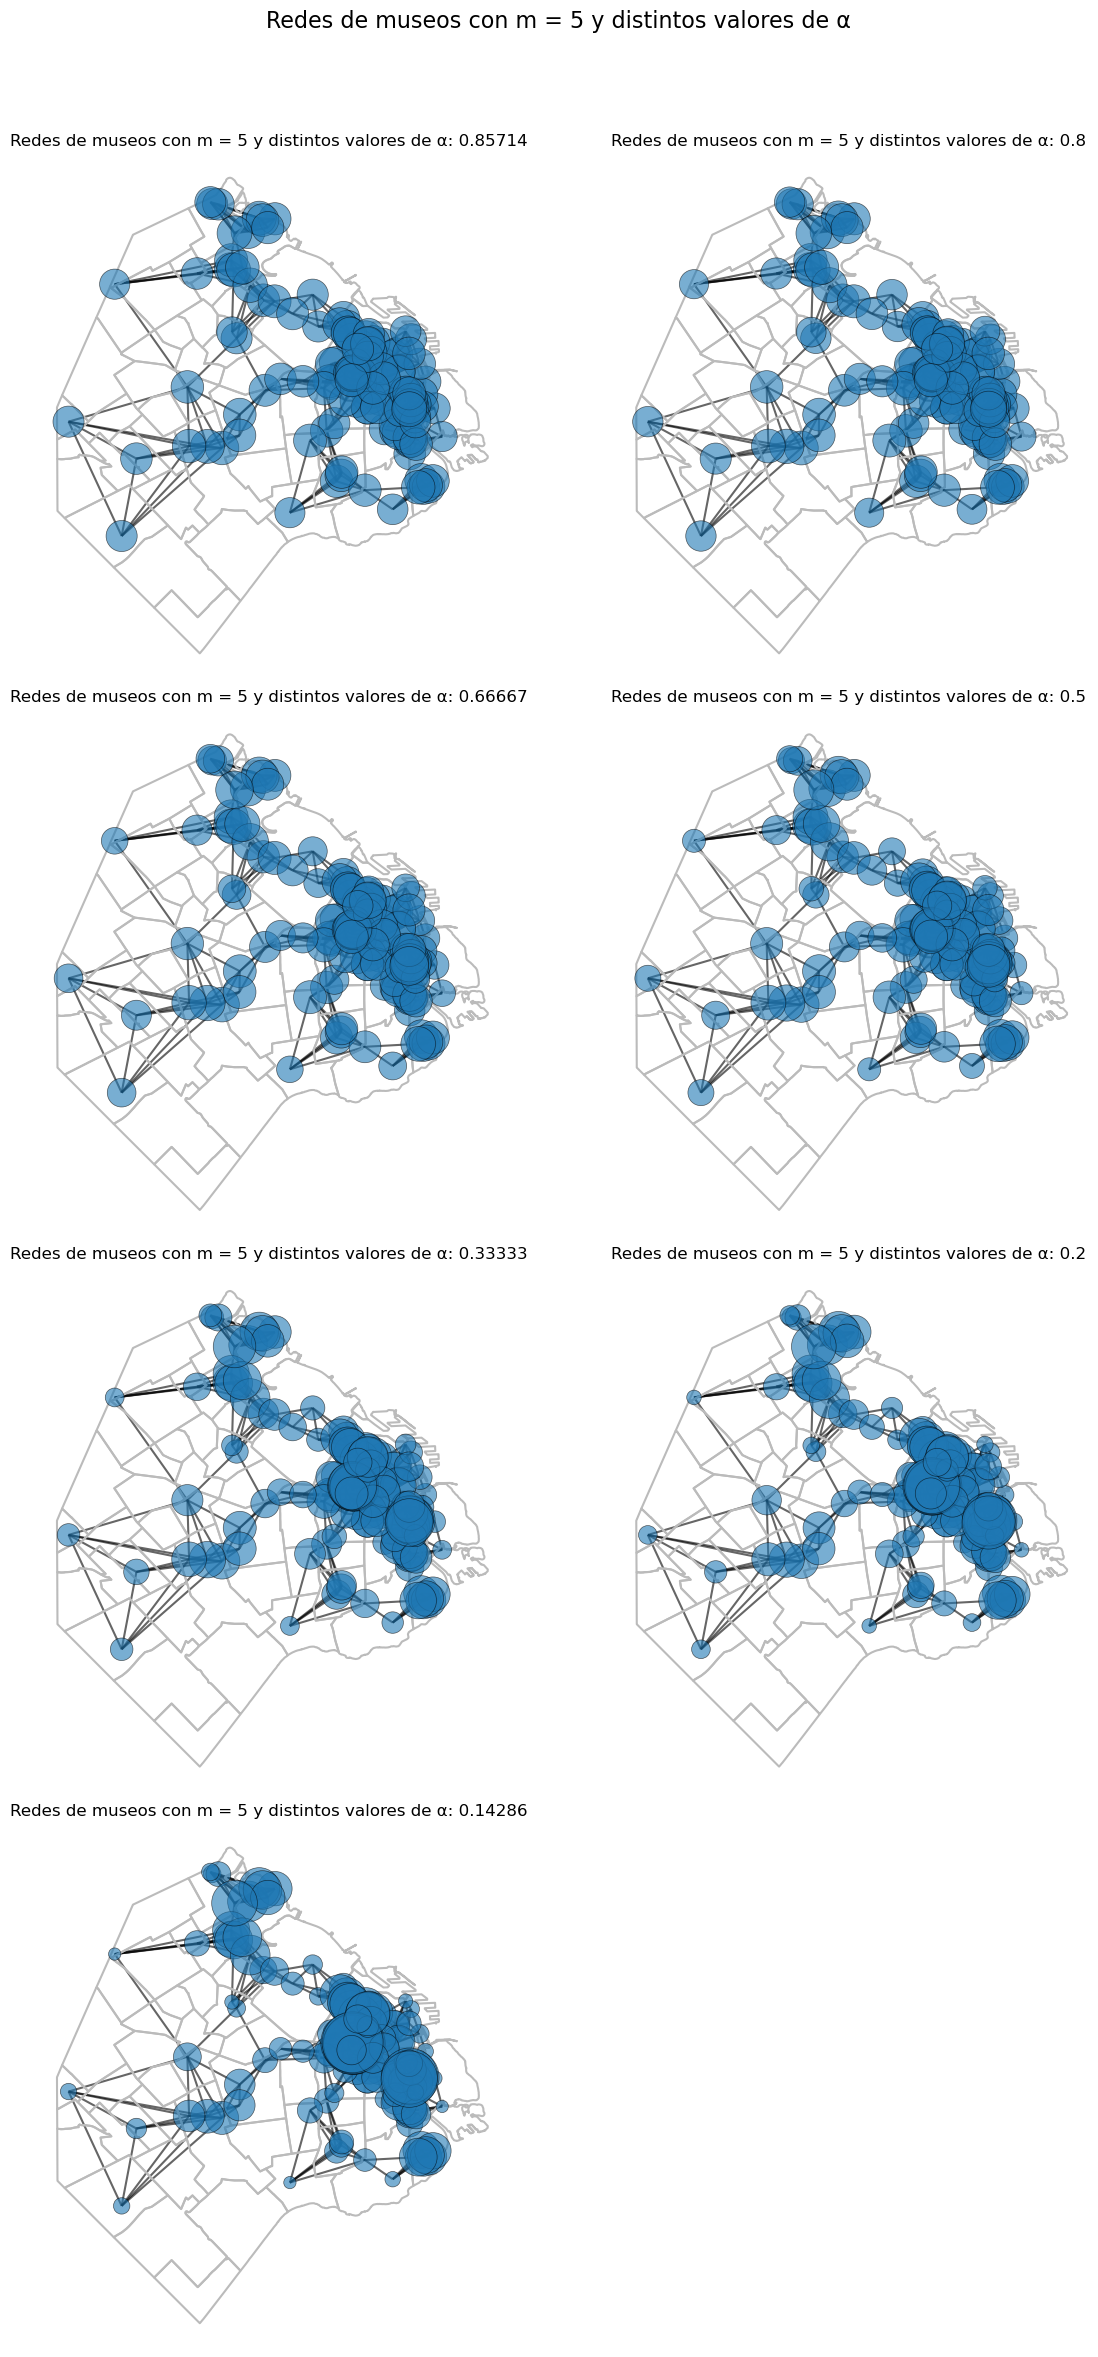

In [13]:
# Mostrar redes para distintos Œ± (con m = 5 fijo)
# Creamos un diccionario de grafos con m=5 fijo
grafos_alfa = {round(alfa, 5): grafos_m[5] for alfa in valores_alfa}

tf.graficar_redes_museos_set(
    grafos=grafos_alfa,
    pageranks=pageranks_alfa,
    G_layout=G_layout,
    barrios=barrios,
    titulo_general="Redes de museos con m = 5 y distintos valores de Œ±"
)

En este caso, como el valor de $m$ est√° fijo en 5, todos los grafos tienen exactamente las mismas conexiones entre museos. Lo que cambia entre gr√°ficos es el valor del par√°metro $\alpha$, que controla la probabilidad de que un caminante reinicie su recorrido en un nodo aleatorio.

Cuando $\alpha$ est√° cerca de 1, por ejemplo $\alpha = \frac{6}{7}$, hay mucha probabilidad de reiniciar la caminata en cualquier museo. Eso hace que los valores de PageRank se repartan de forma bastante uniforme: todos los nodos tienen m√°s o menos el mismo tama√±o. En cambio, cuando $\alpha$ se acerca a 0, como en $\alpha = \frac{1}{7}$, el caminante sigue los enlaces de la red casi sin reiniciar, y eso acent√∫a las diferencias entre nodos. En ese caso, los museos m√°s bien ubicados o con m√°s caminos que llegan a ellos se destacan mucho m√°s.

En resumen, cuanto m√°s chico es $\alpha$, m√°s influye la estructura de la red en el resultado del PageRank. Y cuanto m√°s grande es $\alpha$, m√°s uniforme es la distribuci√≥n del ranking entre los nodos.

---

Para la segunda parte, haremos primero el an√°lisis para $m=5$ y $\alpha = \frac{1}{5}$ y haremos variar $m$ dejando $\alpha$ fijo.

In [49]:
# Obtenemos el top 3 de museos m√°s centrales para m = 5 y ùõº = 1/5
p_copy = pageranks_m[5].copy()
top_idx = []

for i in range(3):
    max_val = -1
    max_idx = -1

    # Recorremos p_copy para buscar el maximo y su posicion
    for idx in range(len(p_copy)):
        if p_copy[idx] > max_val:
            max_val = p_copy[idx]
            max_idx = idx
        
    top_idx.append(max_idx)
    print(f"{i+1}¬∞ ‚Üí Museo #{max_idx} con PageRank = {max_val:.4f}")
        
    # Lo sacamos para encontrar el resto del Top
    p_copy[max_idx] = -1

1¬∞ ‚Üí Museo #93 con PageRank = 0.0217
2¬∞ ‚Üí Museo #125 con PageRank = 0.0216
3¬∞ ‚Üí Museo #117 con PageRank = 0.0211


Ahora analizaremos la evoluci√≥n de estos 3 museos de referencia al variar $m$.

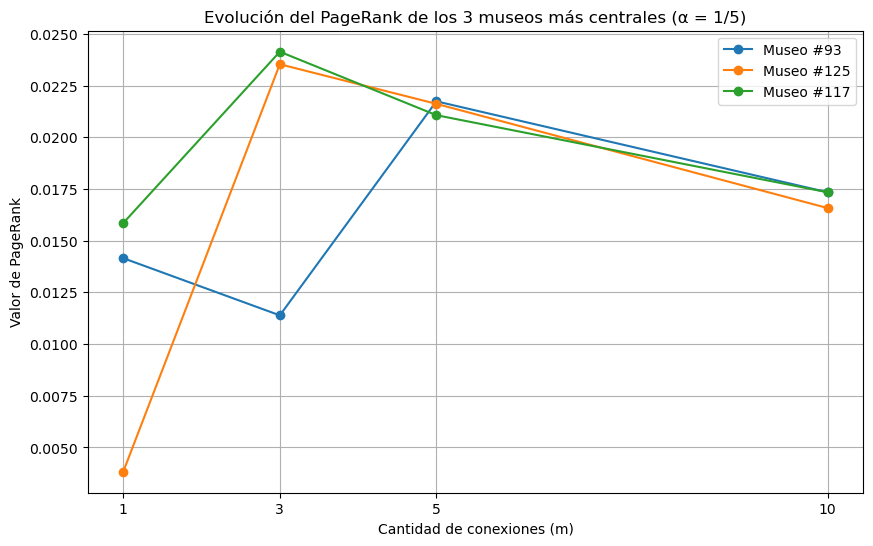

In [50]:
# Inicializamos un diccionario vac√≠o para guardar la evoluci√≥n de cada museo
evolucion_p_m = {idx: [] for idx in top_idx}

# Recorremos cada valor de m
for m in valores_m:
    p = pageranks_m[m]
    for idx in top_idx:
        evolucion_p_m[idx].append(p[idx])  # Guardamos el PageRank correspondiente
        
plt.figure(figsize=(10, 6))

for idx in top_idx:
    plt.plot(valores_m, evolucion_p_m[idx], marker='o', label=f"Museo #{idx}")

# Vector de etiquetas
labels_m = ["1", "3", "5", "10"]
plt.xticks(valores_m, labels_m)  # Aseguramos que se usen los valores como etiquetas expl√≠citas

plt.xlabel("Cantidad de conexiones (m)")
plt.ylabel("Valor de PageRank")
plt.title("Evoluci√≥n del PageRank de los 3 museos m√°s centrales (Œ± = 1/5)")
plt.grid(True)
plt.legend()
plt.show()

Se aprecia que, en general, los valores de PageRank tienden a incrementarse cuando pasamos de $m = 1$ a $m = 3$, y luego decrecen levemente al seguir aumentando $m$ a $5$ y $10$. Esto puede interpretarse como un efecto de dispersi√≥n: con pocas conexiones, la importancia se concentra en unos pocos nodos; a medida que se agregan m√°s enlaces, la centralidad se redistribuye y los valores de PageRank tienden a equilibrarse entre m√°s museos.

---

Hacemos lo mismo pero en funci√≥n de $\alpha$:

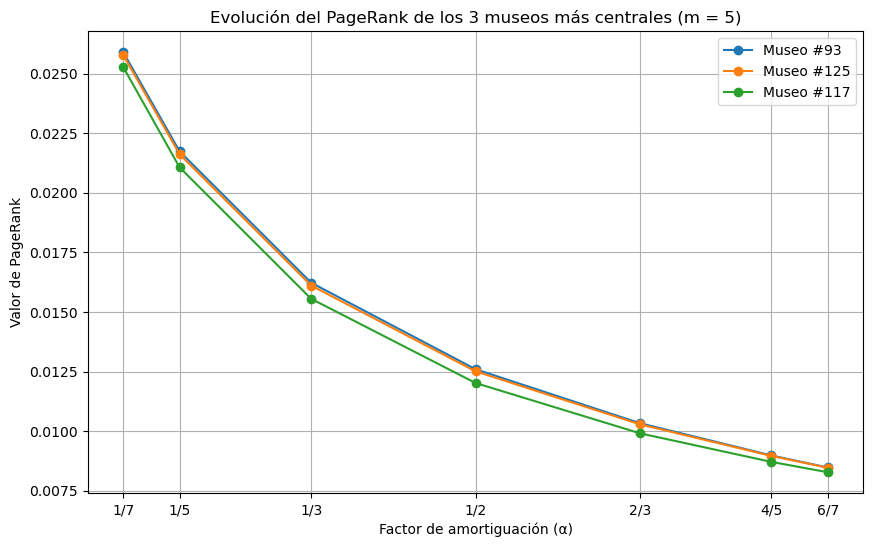

In [51]:
# Inicializamos un diccionario vac√≠o para guardar la evoluci√≥n de cada museo
evolucion_p_alfa = {idx: [] for idx in top_idx}

# Recorremos cada valor de m
for m in valores_alfa:
    p = pageranks_alfa[m]
    for idx in top_idx:
        evolucion_p_alfa[idx].append(p[idx])  # Guardamos el PageRank correspondiente
        
plt.figure(figsize=(10, 6))

for idx in top_idx:
    plt.plot(valores_alfa, evolucion_p_alfa[idx], marker='o', label=f"Museo #{idx}")

# Vector de etiquetas
labels_alfa = ["6/7", "4/5", "2/3", "1/2", "1/3", "1/5", "1/7"]
plt.xticks(valores_alfa, labels_alfa)

plt.xlabel("Factor de amortiguaci√≥n (Œ±)")
plt.ylabel("Valor de PageRank")
plt.title("Evoluci√≥n del PageRank de los 3 museos m√°s centrales (m = 5)")
plt.grid(True)
plt.legend()
plt.show()

Se ve que cuanto m√°s grande es $\alpha$, m√°s se reparten los valores de PageRank entre todos los nodos (recordemos que p es un vector estoc√°stico), y los m√°s centrales bajan un poco. Esto pasa porque al aumentar $\alpha$, el modelo depende m√°s de c√≥mo est√° conectada la red, y menos del "salto aleatorio". En cambio, cuando $\alpha$ es chico, se favorece m√°s a los nodos a los que se llega seguido, y eso hace que se destaquen m√°s en el ranking.

---

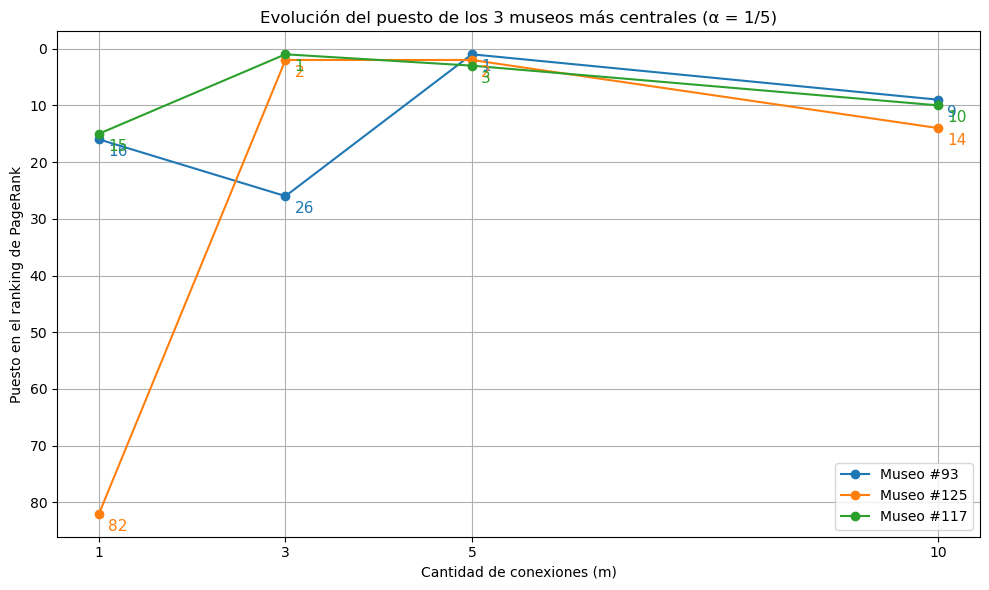

In [47]:
# Diccionario para guardar la evoluci√≥n del puesto de cada museo
puestos_m = {idx: [] for idx in top_idx}

for m in valores_m:
    p = pageranks_m[m]
    
    # Vector de √≠ndices ordenados de mayor a menor
    ranking = np.argsort(p)[::-1]  
    
    for idx in top_idx:
        # np.where devuelve los √≠ndices donde se cumple la condici√≥n del argumento
        puesto = np.where(ranking == idx)[0][0] + 1  # +1 para que el ranking empiece en 1
        puestos_m[idx].append(puesto)


colores = ['tab:blue', 'tab:orange', 'tab:green']
plt.figure(figsize=(10, 6))

for color, idx in zip(colores, top_idx):
    puestos = puestos_m[idx]
    plt.plot(valores_m, puestos, marker='o', label=f"Museo #{idx}", color=color)

    for x, y in zip(valores_m, puestos):
        plt.text(x + 0.1, y + 3, str(y), fontsize=11, color=color)

plt.xticks(valores_m, labels_m)
plt.xlabel("Cantidad de conexiones (m)")
plt.ylabel("Puesto en el ranking de PageRank")
plt.title("Evoluci√≥n del puesto de los 3 museos m√°s centrales (Œ± = 1/5)")
plt.gca().invert_yaxis()
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Podemos observar que al aumentar el valor de $m$ (entre 1 y 10), se observa una notable inestabilidad en el ranking de los museos m√°s centrales. Uno de los museos que ocupa el segundo puesto con $m = 5$ cae al puesto 82 cuando m = 1. Esta gran variaci√≥n sugiere que el n√∫mero de conexiones tiene un impacto decisivo en la estructura de la red: con pocos enlaces ($m$ chico), la red es m√°s local y sensible a cambios puntuales; en cambio, a medida que $m$ crece, el ranking se estabiliza y los museos centrales tienden a mantener posiciones altas. A partir de $m = 5$, los rankings se vuelven m√°s estables entre s√≠.

---

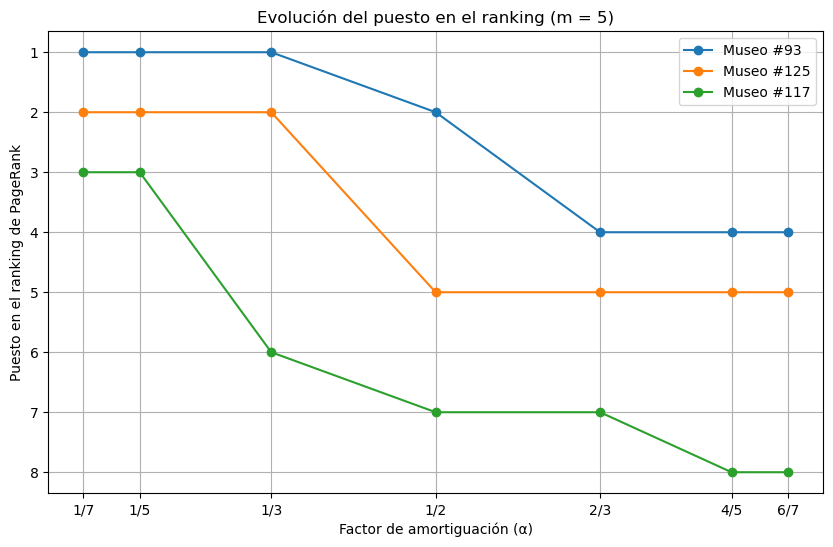

In [48]:
# Diccionario para guardar la evoluci√≥n del puesto de cada museo
puestos_alfa = {idx: [] for idx in top_idx}

for alfa in valores_alfa:
    p = pageranks_alfa[alfa]
    
    # Vector de √≠ndices ordenados de mayor a menor
    ranking = np.argsort(p)[::-1]
    
    for idx in top_idx:
        # np.where devuelve los √≠ndices donde se cumple la condici√≥n del argumento
        puesto = np.where(ranking == idx)[0][0] + 1  # +1 para que el ranking empiece en 1
        puestos_alfa[idx].append(puesto)

# Graficamos los resultados
plt.figure(figsize=(10, 6))

for idx in top_idx:
    plt.plot(valores_alfa, puestos_alfa[idx], marker='o', label=f"Museo #{idx}")

plt.xticks(valores_alfa, labels_alfa)  # Ya hab√≠as definido estas etiquetas como fracciones
plt.xlabel("Factor de amortiguaci√≥n (Œ±)")
plt.ylabel("Puesto en el ranking de PageRank")
plt.title("Evoluci√≥n del puesto en el ranking (m = 5)")
plt.gca().invert_yaxis()
plt.grid(True)
plt.legend()
plt.show()

Al variar $\alpha$ (entre 1/7 y 6/7), se evidencia una estabilidad mucho mayor en los puestos de los museos m√°s centrales. Los tres museos analizados mantienen posiciones altas con variaciones peque√±as y progresivas. Esto indica que el PageRank es menos sensible a cambios en $\alpha$ (dentro del rango considerado), y que los museos m√°s importantes siguen siendo favorecidos en el ranking incluso cuando el peso relativo de la caminata aleatoria frente al salto aleatorio var√≠a.

---

## Punto 4:

Si $V_{0}$ es la distribuci√≥n inicial, o cantidad inicial de visitantes en cada museo, y considero la matriz C, entonces para un elemento i cualquiera de $CV_{0}$, tengo que i = $c_{1,i}*v_{1} + c_{2,i}*v_{2} + \ldots + c_{n,i}*v_{n}$ que no es otra cosa que la suma de la cantidad de visitantes que cada museo distinto del i (si i=j $c_{ij} = 0$) le aporta al i.

De forma an√°loga pero partiendo de otra cantidad inicial $V_{1} = CV_{0}$ nos dara la cantidad de visitantes por museo luego de 2 pasos.
Al final, como menciona el tip, $C^{k}V_{0} = V_{k}$ nos dara la cantida de visitantes por museo luego de k pasos.

Dada la matriz $B$ y $V_{0}$ tengo que: $Bv_{0} = C^{0}v_{0} + C^{1}v_{0} + \ldots + C^{r-1}v_{0}$. Por lo mencionado antes, resulta que, por ejemplo: $C^{0}v_{0} + C^{1}v_{0}$ ser√° la cantidad total de gente que visit√≥ cada museo luego de dos pasos.
En general $C^{0}v_{0} + C^{1}v_{0} + \ldots + C^{r-1}v_{0}$ da la totalidad de visitantes por museo, es decir, w, luego de k pasos.
Si asumo la existencia de $B^{-1}$, para cada r, entonces para cada total de visitantes por museo w tengo la distribuci√≥n inicial $V_{0}$ que lo gener√≥.

## Punto 5:

Usando la ecuaci√≥n  

$$
\mathbf{v} = B^{-1} \mathbf{w}
$$

y suponiendo que las personas dan \( $r = 3$ \) pasos en la red de museos, calcular la cantidad total de visitantes que entraron en la red, $
\|\mathbf{v}\|_1 $
, a partir del vector $ \mathbf{w}\ $ provisto en el archivo `visitas.txt`. Usar para esto la matriz de transiciones definida por la ecuaci√≥n:

$$
C_{ji} = P(i \to j) = \frac{f(d_{ij})}{\sum_{k=1,\, k \ne i}^{N} f(d_{ik})}
$$


Para esto:

- Construya una funci√≥n `calcula_matriz_C_continua` que reciba la matriz de distancias entre museos $ D $ y retorne la matriz $ C $ definida en la ecuaci√≥n anterior.
- Construya una funci√≥n `calcula_B(C, r)` que reciba la matriz $ C $ y el n√∫mero de pasos $ r $ como argumento, y retorne la matriz $
\mathbf{v} = B^{-1} \mathbf{w}
$.
- Utilice la funci√≥n `calculaLU` para resolver la ecuaci√≥n:

$$
\mathbf{v} = B^{-1} \mathbf{w}
$$

In [69]:
w = np.loadtxt("visitas.txt") #Arma vector w a partir del archivo
C = tf.calcula_matriz_C_continua(D) # Construye la matriz de transiciones C
B = tf.calcula_B(C, 3) # Calcula la matriz B que representa la relaci√≥n entre el total de visitas y el n√∫mero inicial de visitantes suponiendo que cada visitante realiz√≥ 3 pasos
v = tf.resolver_con_LU(B, w)

visitantes_totales = np.sum(np.abs(v)) # Calcula norma 1 de v
print("Si las personas dan 3 pasos en la red de museos la cantidad total de visitantes que entraron en la red es ", visitantes_totales)

Si las personas dan 3 pasos en la red de museos la cantidad total de visitantes que entraron en la red es  136605.0


## Punto 6:

Supongan que se enteran de que el n√∫mero total de visitantes por museo $ \mathbf{w} $ tiene un error del 5%, y necesitan estimar c√≥mo se propaga ese error a la estimaci√≥n del n√∫mero inicial $ \mathbf{v} $ de visitantes. Llamemos $ \tilde{\mathbf{w}} $ y $ \tilde{\mathbf{v}} $ los valores reales para el total de visitas y el total de primeras visitas respectivamente.

Si expresamos este problema usando el n√∫mero de condici√≥n, tenemos que:

$$
\frac{\|\mathbf{v} - \tilde{\mathbf{v}}\|_1}{\|\mathbf{v}\|_1} \leq \text{cond}_1(B) \cdot \frac{\|\mathbf{w} - \tilde{\mathbf{w}}\|_1}{\|\mathbf{w}\|_1}
$$

Calcule el n√∫mero de condici√≥n de $ B $ y estime la cota para el error de estimaci√≥n de $ \mathbf{v} $.

In [73]:
cond_B = tf.condicion_1_por_LU(B)# N√∫mero de condici√≥n de B
error_v = cond_B * 0.05 # La cota para el error de estimaci√≥n de v

print("El n√∫mero de condici√≥n 1 de B es", cond_B)
print("La cota para el error de estimaci√≥n de v es", error_v)

El n√∫mero de condici√≥n 1 de B es 5.051771176665005
La cota para el error de estimaci√≥n de v es 0.25258855883325027
